In [1]:
import numpy as np

from keras.datasets import boston_housing

Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

### Цель - медианные значения цен на дома, в тыс.

### Нормализация данных, т.к. все они приведены в разных шкалах

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

##### Далее не ошибка. Тестовые данные нормализуция с mean и std от обучающих. Не надо использовать значения, рассчитанные на контрольных данных, т.к. их условно нет, даже для нормализации 

In [7]:
test_data -= mean
test_data /= std

### Определение модели

In [8]:
from keras import models
from keras import layers

In [13]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

### Перекрестная проверка по К блокам:


In [15]:
k = 4
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                        train_data[(i + 1) * num_val_samples:]],
                                       axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                           train_targets[(i + 1)*num_val_samples:]],
                                          axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [16]:
all_scores

[2.1705100536346436, 2.4750871658325195, 2.5579118728637695, 2.566660165786743]

In [18]:
np.mean(all_scores)

2.442542314529419

### 500 эпох, сохранение оценки проверки

In [22]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                        train_data[(i + 1) * num_val_samples:]],
                                       axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                           train_targets[(i + 1)*num_val_samples:]],
                                          axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_loss']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [31]:

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)] 

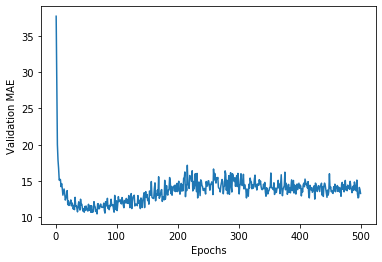

In [33]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### График проверок без первых 10 замеров с заменой на экспоненциальное скользящее среднее

In [40]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

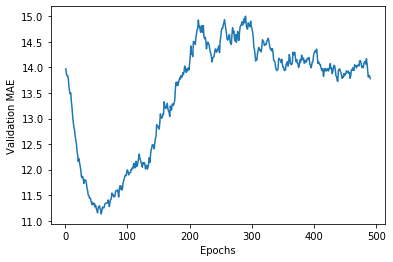

In [42]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1,len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### Наилучшая MAE оценка достигается при ~ 80 эпохах
## Окончательная модель

In [45]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 559us/step


In [46]:
test_mae_score

2.86053729057312